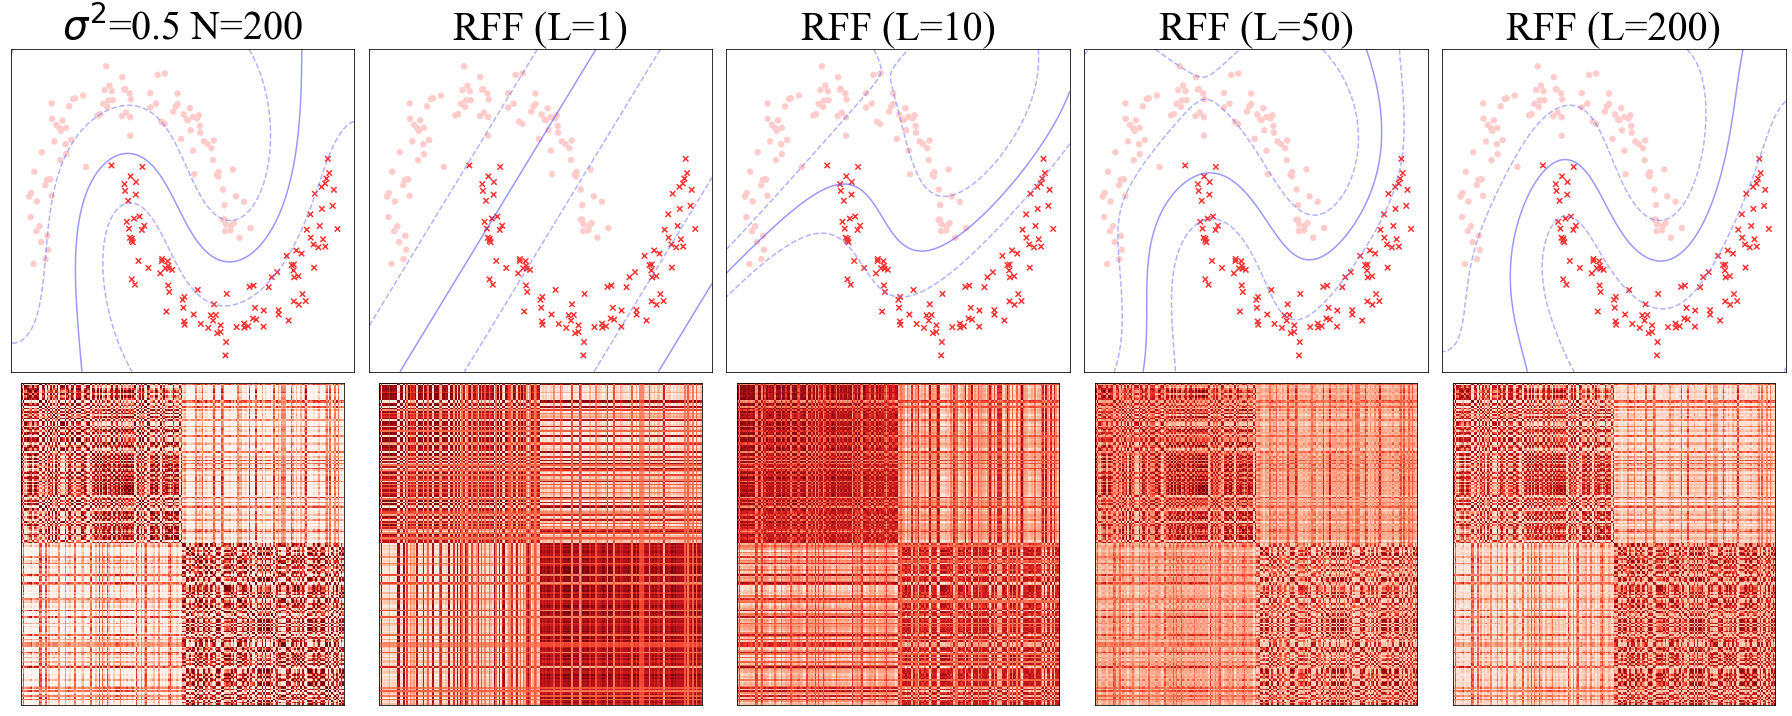

In [5]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.metrics.pairwise import rbf_kernel


## Data
d = 2
N = 200
X, y = datasets.make_moons(n_samples=N, noise=.1, random_state=1)
I = y.argsort()
X, y = X[I], y[I]


##  Kernels 
sigma2 = 0.5
gamma = 1/(2*sigma2)

def rbf_exact_kernel(X, Y):
    K = rbf_kernel(X, Y, gamma=gamma)
    return K

def get_rbf_rff_kernel(L):
    W = npr.normal(0, np.sqrt(1/sigma2), size=(d,L))
    b = npr.uniform(0, 2*np.pi, size=(1,L))
    rff_map = lambda X: np.sqrt(2/L) * np.cos(X@W + b)

    def rbf_rff_kernel(X,Y):
        Zx = rff_map(X)
        Zy = rff_map(Y)
        K = Zx@Zy.T
        return K
    
    return rbf_rff_kernel

kernels = {
    f'$\sigma^2$={sigma2} N={N}':  rbf_exact_kernel,
    f'RFF (L={1})':    get_rbf_rff_kernel(1),
    f'RFF (L={10})':   get_rbf_rff_kernel(10),
    f'RFF (L={50})':   get_rbf_rff_kernel(50),
    f'RFF (L={200})':  get_rbf_rff_kernel(200),
}

## Plotting
ht = 5
ncols = 5
fig, axs = plt.subplots(2, 1*ncols)
fig.set_size_inches(ht*ncols, 2*ht)
font = {'fontsize': 40, 'fontname': 'Times New Roman'}
cmap      = plt.cm.get_cmap('bwr')

for i, (kernel_name, kernel) in enumerate(kernels.items()):
    
    ax = axs[0,i]
    mask0 = np.ma.masked_where(y==0, [30 for _ in range(N)])
    mask1 = np.ma.masked_where(y==1, [30 for _ in range(N)])
    ax.scatter(X[:,0], X[:,1], s=mask0, c=[cmap(0.9)], marker='x')
    ax.scatter(X[:,0], X[:,1], s=mask1, c=[cmap(0.6)], marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    clf = svm.SVC(kernel=kernel)
    clf.fit(X, y)

    XX, YY = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 100),
        np.linspace(ylim[0], ylim[1], 100))
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors=[cmap(0.2),cmap(0.1),cmap(0.2)],
               levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    if clf.support_vectors_.shape[0] != 0:
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                       linewidth=1, facecolors='none', edgecolors=cmap(0.95))
    ax.set_title(kernel_name, **font)
    
    ax = axs[1,i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(kernel(X,X), cmap=plt.cm.Reds, interpolation='nearest')
    

plt.tight_layout()
save_path = './summary/assets/rbf_rff_svm.png'
fig.savefig(save_path, bbox_inches='tight', dpi=100)

